## Final Project Submission

Please fill out:
* __Student name:__ Cassarra Groesbeck
* __Student pace:__ Part Time/ Flex
* __Scheduled project review date/time:__ 
* __Instructor name:__ Claude Fried
* __Blog post URL:__


# Introduction 

The goal of this linear regression model is to make inferences as to how renovations can increase the estimated value of a home located in King County WA. A real estate company has tasked me with evaluating what features increase home sales, and by how much. This company is interested in providing homeowners with insightful recommendations about how to invest their renovation dollars to boost the value of their home. They want at least three specific features that boost sale price, and they would like to know by much will each feature increase the value of the home.

## Objectives

Provide a metric describing overall model performance.
Provide at least three features that increase sale price, and by how much

## Business Understanding

The real estate agency needs to provide information to homeowners about how home renovations might increase the estimated value of their homes, and by what amount.
Final recommendations, based on this models coeffiecient values, are listed in section [**Final Recommendations**](#final_recos)



# Data Understanding
This project uses the King County House Sales dataset. For more information, other than what is provided below, see the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r)

###  Column Names and Descriptions for King County Data Set

<a id='table'></a>


| Column     | Description   |
|------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  `id`         | **Unique identifier for a house**  |
| `date`        | **Date house was sold**  |
| `price`       | **Sale price (prediction target)** |
| `bedrooms`    | **Number of bedrooms**  |
|`bathrooms`    | **Number of bathrooms**   |
|`sqft_living`  | **Square footage of living space in the home**  |
| `sqft_lot`    | **Square footage of the lot**   |
|  `floors`     | **Number of floors (levels) in house**  |
| `waterfront`  | **Whether the house is on a waterfront**  |
| `view`        | **Quality of view from house** |
| `condition`   | **How good the overall condition of the house is. Related to maintenance of house.**  |
| `grade`       | **Overall grade of the house. Related to the construction and design of the house.**  |
| `sqft_above`  | **Square footage of house apart from basement**  |
|`sqft_basement`| **Square footage of the basement**   |
|  `yr_built`   | **Year when house was built**  |
| `yr_renovated`| **Year when house was renovated**  |
| `zipcode`     | **ZIP Code used by the United States Postal Service** |
| `lat`         | **Latitude coordinate**  |
| `long`        | **Longitude coordinate**   |
|`sqft_living15`| **The square footage of interior housing living space for the nearest 15 neighbors**   |
| `sqft_lot15`  | **The square footage of the land lots of the nearest 15 neighbors**   |



# Imports

In [1]:
# The basics
import pandas as pd
import numpy as np

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# statsmodels
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# scipy
import scipy.stats as stats

# rando
from itertools import combinations

#visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

# Bring in the data

In [2]:
# data/kc_house_data.csv
data = pd.read_csv("data/kc_house_data.csv")
data.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287
21596,1523300157,10/15/2014,325000.0,2,0.75,1020,1076,2.0,NO,NONE,...,7 Average,1020,0.0,2008,0.0,98144,47.5941,-122.299,1020,1357


# Functions

Takes in pandas df and target, returns the fit statsmodel with constant. For assumption checks and .summary() reports

In [3]:
# function to fit statsmodel
def model(df, target):
    y = df[target]
    X = df.drop(target, axis=1)

    model = sm.OLS(y, sm.add_constant(X)).fit()
    
    return model

This function does most of the heavy lifting. It takes in pandas df and target and returns just the .summary() table with coefficients, t, p, and ci values. Additionally, it will return small plots of residual distributions in histo and qq plot. As well as r-squared and adjusted r-squared from statsmodel, and kfold crossvalidation with 3 splits.

In [4]:
# function to return r_squared values, coeff /p table from .summary, and a 
# couple of residual normality checks (hist and qq plot)

def model_it_small(df, target):
    y = df[target]
    X = df.drop(target, axis=1)
    #statsmodel fit
    model = sm.OLS(y, sm.add_constant(X)).fit()  
    
    #kfold
    regression = LinearRegression()
    crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)
    kfold_r = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
    
    #PLOTS
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle('Normality of Residuals')
    #hist
    sns.histplot(model.resid, ax=ax0)
    ax0.set(xlabel='Residual', ylabel='Frequency', title='Distribution of Residuals')
    #qq
    sm.qqplot(model.resid, fit = True, line = '45', ax=ax1)
    ax1.set(title='QQ Plot')
    plt.show()
    
    #print r_squared values
    print(f'r_sq: {model.rsquared}. r_sq_adjusted: {model.rsquared_adj}. k_fold_r: {kfold_r}')
    
    #return 
    return model.summary().tables[1]



This is used know what feature to use to build baseline model with aswell as in conjunction with VIF function. It takes in a pandas df and gets the absolute values of the correlations between the variables, sorts them, then returns just those features with values greater than .75 and less than 1. And finally it drops the duplicates. I like to have an additional way of seeing how things are relating to other features other than just and VIF number.

In [5]:
# collinearity check function
# code from Multicollinearity of Features - Lab, turned it into a function

def collinearity(df):
    #get absolute value of correlations, sort them, and turn into new DF called df
    df=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

    # zip the columns (Which were only named level_0 and level_1 by default) 
    # into a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))

    # set index to pairs
    df.set_index(['pairs'], inplace = True)

    # drop level_ columns
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    # rename correlation column as cc rather than 0
    df.columns = ['cc']

    # just correlations over .75, but less than 1.
    df = df[(df.cc>.75) & (df.cc <1)]

    df.drop_duplicates(inplace=True) 

    return df

This function is used in the Independence Assumption check. It returns features that have a VIF greater than 5

In [6]:
# colinearity with VIF
# code from Linear Regression - Cumulative Lab, altered to make a df w/sorted values

def get_VIFs_above5(df, target):

    vif_data = sm.add_constant(df.drop(target, axis=1))

    vif = [variance_inflation_factor(vif_data.dropna().values, i)\
           for i in range(vif_data.dropna().shape[1])]

    vif_df = pd.DataFrame(vif, index=vif_data.columns).sort_values(0, ascending=False)
    return vif_df[vif_df[0]>5]

This function take in a pandas df and the column/feature in which you would like to remove outliers and returns a new df with that features outliers removed using scipy.stats.zscore of less than 3 

In [7]:
# remove outliers from a feature
def remove_outliers(df, column):
    return df[(np.abs(stats.zscore(df[column])) < 3)]

This function will aid in final recommendations as it returns the coefficients in easy to understand percentage_of_change in target variable. It takes in a pandas df and target and returns a pandas df with predictor coefficient as percentages

In [8]:
def coeffs_as_percent_df(df, target_variable):
    """
    takes in a pandas dataframe and target_variable 
    (intercept) as a string, ie column name, and returns
    df with predictor coefficients as percentage_of_change 
    in target variable
    """

    # remove target from df
    predictors = df.drop(target_variable, axis=1)
    
    # import the magic sauce
    from sklearn.linear_model import LinearRegression
    linreg = LinearRegression()
    linreg.fit(predictors, df[target_variable])
    
    # get the what will become the values
    predictors_coeffs = list(linreg.coef_)

    # give it a new name
    all_values = [f'{round((coeff*100), 2)}%' for coeff in predictors_coeffs]

    # what will become the keys...
    predictor_names = list(predictors.columns)

    # give it a new name
    all_keys = predictor_names

    # zip into dictionary
    coeff_dict = dict(zip(all_keys, all_values))
    
    # make df
    coeff_df = pd.DataFrame(list(coeff_dict.items()))
    
    # rename columns
    coeff_df.rename(columns={0: "coeff", 1: "change_in_target"}, inplace=True)
    
    return coeff_df


In [9]:
# normality check function, returns hist of residuals and qq plot
def normality_check(df, target):
    
    # fit statsmodel with function
    fit_model = model(df, target)
    
    # establish plots
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    
    # histo
    sns.histplot(fit_model.resid, ax=ax0)
    ax0.set(xlabel='Residual', ylabel='Frequency', title='Distribution of Residuals')
    
    # qq plot
    sm.qqplot(fit_model.resid, fit = True, line = '45', ax=ax1)
    ax1.set(title='QQ Plot')
    
    # title for entire thing
    fig.suptitle('Normality of Residuals')
    
    # show me just the plot
    plt.show()

# Exploring the and transforming data:

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Identify target variable 

In [11]:
target = 'price'

## Extract Catagorical Variables

In [12]:
obj_df = data.select_dtypes(include=object)
obj_df.head()

,date,waterfront,view,condition,grade,sqft_basement
0,10/13/2014,NaN,NONE,Average,7 Average,0.0
1,12/9/2014,NO,NONE,Average,7 Average,400.0
2,2/25/2015,NO,NONE,Average,6 Low Average,0.0
3,12/9/2014,NO,NONE,Very Good,7 Average,910.0
4,2/18/2015,NO,NONE,Average,8 Good,0.0


#### Explore catagorical variables

- [x] `'date'` (stays categorical)
- [x] `'waterfront'` (will become boolean)
- [x] `'view'` (stays categorical)
- [x] `'condtion'` (stays categorical)
- [x] `'grade'` (ordinal)
- [x] `'sqft_basement'` (will become boolean)

### Findings from obj_df exploration:
- `'waterfront'`
 - has two values: NO & YES
 - has 2376 nulls, that will need to be addressed before ohe'ing
 - 11% of data is null/ missing
 - 0.7% of properties are waterfront
 - 88.3% of properites are not on waterfront
 - I will change nulls to NO due to less than 1% of properties on waterfront
- `'condition'`
 - 5 unique values
 - has zero nulls
- `'view'`
 - has 6 values 
 - 89.93% is 'NONE'
 - 63 nulls (0.29%), change to 'NONE' 
- `'grade'`
 - 11 unique values
 - has numeric value (3-13) and word description (ex "poor" or "good") associated with each grade assignment
 - need to change to just number grade and delete description
- `'date'` 
 - string: 'mm/dd/yyyy'
- `'sqft_basement'`
 - float values cast as string
 - 454 missing, shown as '?', 2% missing
 - 12826 '0.0' basement, ie 59% no basement, add new column "has_basement"


**Prep list to get obj_df features get_dummies-ready. I will add to this list as I explore data and will address needed conversions at end before get_dummies.**

1. [x] replace `'waterfront'` {np.nan:'NO'} - this will be a boolean feature
2. [x] change `'view'` nulls to 'NONE' - will stay catagorical
3. [x] keep `'grade'` number and ditch description - this will make the feature ordinal
4. [x] convert `'date'` to just numerical month - then seperate by season, change name to `'season_sold'`
5. [x] for `'sqft_basement'` make new column `'has_basement'` with NO or YES
6. [x] if value '0.0' or '?' append new column NO, else YES - this will be a boolean feature
7. [x] make new get_dummies_df of [`'view'`, `'condition'`, `'has_basement'`, `'waterfront'`]
8. [x] pd.get_dummies(dummies_df, drop_first=True)

<a id='values'></a>
### Column Values and Null Counts:

In [13]:
# print .value_counts() for each column in obj_df
for column in obj_df.columns:
    print(f"COLUMN: '{column}'")
    print(f"Number of unique values: {len(obj_df[column].unique())}")
    print(f"Number of nulls: {obj_df[column].isnull().sum()}")
    print(obj_df[column].value_counts())
    print()

COLUMN: 'date'
Number of unique values: 372
Number of nulls: 0
6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
            ... 
11/2/2014      1
5/24/2015      1
5/27/2015      1
2/15/2015      1
1/10/2015      1
Name: date, Length: 372, dtype: int64

COLUMN: 'waterfront'
Number of unique values: 3
Number of nulls: 2376
NO     19075
YES      146
Name: waterfront, dtype: int64

COLUMN: 'view'
Number of unique values: 6
Number of nulls: 63
NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

COLUMN: 'condition'
Number of unique values: 5
Number of nulls: 0
Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

COLUMN: 'grade'
Number of unique values: 11
Number of nulls: 0
7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair       

In [14]:
#  null counts
obj_df.isnull().sum()

date                0
waterfront       2376
view               63
condition           0
grade               0
sqft_basement       0
dtype: int64

In [15]:
obj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           21597 non-null  object
 1   waterfront     19221 non-null  object
 2   view           21534 non-null  object
 3   condition      21597 non-null  object
 4   grade          21597 non-null  object
 5   sqft_basement  21597 non-null  object
dtypes: object(6)
memory usage: 1012.5+ KB


In [16]:
# 'sqft_basement' has '?' for a value ...?
obj_df[['sqft_basement']].head(20)

,sqft_basement
0,0.0
1,400.0
2,0.0
3,910.0
4,0.0
5,1530.0
6,?
7,0.0
8,730.0
9,0.0


In [17]:
#confirm date is string 
type(obj_df['date'][0])

str

### Tackeling get_dummies prep list

In [18]:
# 1. replace 'waterfront' {np.nan:'NO'}
data['waterfront'].replace({np.nan:'NO'}, inplace=True)

#check
data['waterfront'].value_counts()

NO     21451
YES      146
Name: waterfront, dtype: int64

In [19]:
# 2. change 'view' nulls to 'NONE'
data['view'].fillna('NONE', inplace=True)

#check
data['view'].value_counts()

NONE         19485
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [20]:
# 3. keep 'grade' number (as an int) and ditch description
data['grade'] = [int(grade[:2]) for grade in data['grade']]

#check
data['grade'].value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

In [21]:
# 4. convert 'date' to just numerical month
data['date'] = pd.DatetimeIndex(data['date']).month

# catagorize into seasons
seasons = {1:'winter', 2:'winter', 3:'spring',
          4:'spring', 5:'spring', 6:'summer',
          7:'summer', 8:'summer', 9:'fall',
          10:'fall', 11:'fall', 12:'winter'}
    
data['date'] = data['date'].replace(seasons)

# rename date to what it is
data.rename({'date':'season_sold'}, axis=1, inplace=True)

#check
data['season_sold'].value_counts()

spring    6518
summer    6328
fall      5056
winter    3695
Name: season_sold, dtype: int64

In [22]:
# 5. & 6. for 'sqft_basement' make new column "has_basement"
# if value '0.0' or '?' append new column 0, else 1

basement = []
for square_feet in data['sqft_basement']:
    if square_feet == '0.0':
        basement.append('NO')
    elif square_feet == '?':
        basement.append('NO')
    else:
        basement.append('YES')
        
data['has_basement'] = basement

#drop 'TotalBsmtSF'
data = data.drop('sqft_basement', axis=1)

# check 
data.head()

,id,season_sold,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,has_basement
0,7129300520,fall,221900.0,3,1.00,1180,5650,1.0,NO,NONE,...,7,1180,1955,0.0,98178,47.5112,-122.257,1340,5650,NO
1,6414100192,winter,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7,2170,1951,1991.0,98125,47.7210,-122.319,1690,7639,YES
2,5631500400,winter,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6,770,1933,NaN,98028,47.7379,-122.233,2720,8062,NO
3,2487200875,winter,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7,1050,1965,0.0,98136,47.5208,-122.393,1360,5000,YES
4,1954400510,winter,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8,1680,1987,0.0,98074,47.6168,-122.045,1800,7503,NO


In [23]:
# 7. make new dummies_df of ['view','condition', 'has_basement', 'waterfront', 'season_sold']
dummies_cols = data[['view','condition', 'has_basement', 'waterfront', 'season_sold']]
dummies_cols

,view,condition,has_basement,waterfront,season_sold
0,NONE,Average,NO,NO,fall
1,NONE,Average,YES,NO,winter
2,NONE,Average,NO,NO,winter
3,NONE,Very Good,YES,NO,winter
4,NONE,Average,NO,NO,winter
...,...,...,...,...,...
21592,NONE,Average,NO,NO,spring
21593,NONE,Average,NO,NO,winter
21594,NONE,Average,NO,NO,summer
21595,NONE,Average,NO,NO,winter


In [24]:
# 8. pd.get_dummies(dummies_df, drop_first=True)
dummies_df = pd.get_dummies(dummies_cols, drop_first=True)
dummies_df.head()

,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,condition_Fair,condition_Good,condition_Poor,condition_Very Good,has_basement_YES,waterfront_YES,season_sold_spring,season_sold_summer,season_sold_winter
0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,1,1,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,0,0,1


### DUMMIES DROPPED NOTES:
Take note of the features that have been dropped:
- `'view_AVERAGE'` has been dropped
- `'condition_AVERAGE'` dropped
- `'has_basement_NO'` dropped
- `'waterfront_NO'` dropped
- `'season_sold_fall'` dropped


## Extract Continuous Variables

In [25]:
# extract out columns with Dtype == int or float for further exploration
cont_df = data.select_dtypes(exclude=object).drop(['id', 'price'], axis=1)
cont_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,7,1180,1955,0.0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,7,2170,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,6,770,1933,NaN,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,7,1050,1965,0.0,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,8,1680,1987,0.0,98074,47.6168,-122.045,1800,7503


### __NOTES:__ 
`'zipcode'` is an integer but should be a catagorical variable. It will need to be transformed somehow before get_dummies and concatenated to `dummies_df`.

In [26]:
# check for nulls 
cont_df.isnull().sum()

bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
grade               0
sqft_above          0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### __NOTES:__ 
3,842 missing values from `'yr_renovated'`. Thats too many for imputations or replacement. Nulls may mean N/A. Could turn into boolean: 'renovated_YES' == 1

In [27]:
cont_df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

### __NOTES:__ 
An additional 17,011 values of 0, ie 0 likely means N/A and missing values are just that, missing. That is in fact too many for imputations or replacement. I will need to drop this column.

## Converting zip code to cites

In [28]:
data['zipcode'].value_counts() # ohe these? Find way to reduce. 

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

### Web Scrapping for City Zip Codes

__Extract out just zipcode and city from https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033__

In [29]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [30]:
html_page = requests.get('https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033') # Make a get request to retrieve the page
soup = BeautifulSoup(html_page.content, 'html.parser') # Pass the page contents to beautiful soup for parsing


In [31]:
#soup.prettify

In [32]:
#grab an easy to identify thing
span = soup.find('span')

# move up to find sibling of container I want
parent = span.parent

# get to the correct container
box = parent.next_sibling.next_sibling

# get text from container and format how needed
box_text = box.get_text().replace('\n', ',')
box_text = box_text.replace('Zip CodeCityCounty', '')
box_text = box_text.replace('King County,', '')
box_text = box_text.replace(' ... ', '')

# split on the commas and remove last (empty) element
lst = box_text.split(",")
lst.pop()

#check
lst

['98001',
 'Algona',
 '98001',
 'Auburn',
 '98001',
 'Federal Way',
 '98002',
 'Auburn',
 '98003',
 'Auburn',
 '98003',
 'Federal Way',
 '98004',
 'Beaux Arts Village',
 '98004',
 'Bellevue',
 '98004',
 'Clyde Hill',
 '98004',
 'Hunts Point',
 '98004',
 'Yarrow Point',
 '98005',
 'Bellevue',
 '98006',
 'Bellevue',
 '98007',
 'Bellevue',
 '98008',
 'Bellevue',
 '98009',
 'Bellevue',
 '98010',
 'Black Diamond',
 '98011',
 'Bothell',
 '98013',
 'Burton',
 '98013',
 'Vashon',
 '98014',
 'Carnation',
 '98015',
 'Bellevue',
 '98019',
 'Duvall',
 '98022',
 'Enumclaw',
 '98023',
 'Auburn',
 '98023',
 'Federal Way',
 '98024',
 'Fall City',
 '98025',
 'Hobart',
 '98027',
 'Issaquah',
 '98028',
 'Kenmore',
 '98028',
 'Bothell',
 '98029',
 'Issaquah',
 '98030',
 'Kent',
 '98031',
 'Kent',
 '98032',
 'Kent',
 '98033',
 'Kirkland',
 '98034',
 'Kirkland',
 '98035',
 'Kent',
 '98038',
 'Maple Valley',
 '98039',
 'Medina',
 '98040',
 'Mercer Island',
 '98041',
 'Bothell',
 '98042',
 'Covington',
 '9804

In [33]:
# seperate into two lists: codes and cities
codes = []
cities = []
i=0
for element in lst:
    if i %2 == 0:
        codes.append(element)
        i+=1
    else:
        cities.append(element)
        i+=1

### Make a DF with `code` and `cities` lists

In [34]:
# use the two lists to make a DF
# empty df
web_df = pd.DataFrame()
web_df['zipcode_web']  = codes
web_df['city_web']  = cities

#check
web_df.head()

,zipcode_web,city_web
0,98001,Algona
1,98001,Auburn
2,98001,Federal Way
3,98002,Auburn
4,98003,Auburn


In [35]:
# use DF to make a dict of 
dictionary = {}
for key in web_df['zipcode_web'].unique():
      dictionary[key] = str(web_df[web_df['zipcode_web'] == key]['city_web'].unique())
        
# check
dictionary

{'98001': "['Algona' 'Auburn' 'Federal Way']",
 '98002': "['Auburn']",
 '98003': "['Auburn' 'Federal Way']",
 '98004': "['Beaux Arts Village' 'Bellevue' 'Clyde Hill' 'Hunts Point' 'Yarrow Point']",
 '98005': "['Bellevue']",
 '98006': "['Bellevue']",
 '98007': "['Bellevue']",
 '98008': "['Bellevue']",
 '98009': "['Bellevue']",
 '98010': "['Black Diamond']",
 '98011': "['Bothell']",
 '98013': "['Burton' 'Vashon']",
 '98014': "['Carnation']",
 '98015': "['Bellevue']",
 '98019': "['Duvall']",
 '98022': "['Enumclaw']",
 '98023': "['Auburn' 'Federal Way']",
 '98024': "['Fall City']",
 '98025': "['Hobart']",
 '98027': "['Issaquah']",
 '98028': "['Kenmore' 'Bothell']",
 '98029': "['Issaquah']",
 '98030': "['Kent']",
 '98031': "['Kent']",
 '98032': "['Kent']",
 '98033': "['Kirkland']",
 '98034': "['Kirkland']",
 '98035': "['Kent']",
 '98038': "['Maple Valley']",
 '98039': "['Medina']",
 '98040': "['Mercer Island']",
 '98041': "['Bothell']",
 '98042': "['Covington' 'Kent']",
 '98045': "['North B

### Make new column on exisiting `data` df

In [36]:
type(data['zipcode'][0])

numpy.int64

In [37]:
#copy zipcode to new column
data['Location/Area'] = data['zipcode'].astype(str)

In [38]:
# Use dictionary to replace zipcodes with cities
data['Location/Area'] = data['Location/Area'].replace(dictionary)

__Distill Cities down to Areas__

In [39]:
# use new column (now containing city names) to begin a list of areas
new_values = []
for cities in data['Location/Area']:
    if 'Seattle' in cities:
        new_values.append('Seattle Area')
    elif 'Bellevue' in cities:
        new_values.append('Bellevue Area')
    elif 'Auburn' in cities:
        new_values.append('Auburn Area')
    elif 'Kent' in cities:
        new_values.append('Kent Area')
    else:
        new_values.append(cities)

In [40]:
# change column values from cities to Areas (when possible) otherwise remains city name
data['Location/Area'] = new_values

In [41]:
# check
data['Location/Area'].value_counts()

Seattle Area                8973
Auburn Area                 1690
Bellevue Area               1407
Kent Area                   1201
['Redmond']                  977
['Kirkland']                 977
['Newcastle' 'Renton']       874
['Issaquah']                 733
['Renton']                   723
['Maple Valley']             589
['Sammamish' 'Redmond']      441
['Sammamish' 'Issaquah']     359
['Snoqualmie']               308
['Kenmore' 'Bothell']        283
['Mercer Island']            282
['Woodinville']              273
['Enumclaw']                 233
['North Bend']               220
98077                        198
['Bothell']                  195
['Duvall']                   190
['Carnation']                124
['Vashon']                   117
['Black Diamond']            100
['Fall City']                 80
['Medina']                    50
Name: Location/Area, dtype: int64

### __NOTES:__
- [x] '98077' needs a City name: Woodinville
- [x] if two cites, assign an area
 - [x] Bothell area: Kenmore, _Bothell_
 - [x] Bellevue Area: _Kirkland_
 - [x] Sammamish Area: _Sammamish_, _Issaquah_, _Redmond_
 - [x] Newcastle area: Newcastle, _Renton_

In [42]:
# repeat above, further distilling values from 'Location/Area' column
new_values2 = []
for cities in data['Location/Area']:
    if 'Bothell' in cities:
        new_values2.append('Bothell Area')
    elif 'Kirkland' in cities:
        new_values2.append('Bellevue Area')
    elif 'Renton' in cities:
        new_values2.append('Newcastle Area')
    elif 'Sammamish' in cities:
        new_values2.append('Sammamish Area')
    elif 'Issaquah' in cities:
        new_values2.append('Sammamish Area')
    elif 'Redmond' in cities:
        new_values2.append('Sammamish Area')
    elif cities == '98077':
        new_values2.append('Woodinville')
    else:
        new_values2.append(cities.strip("['']"))

# change column values to new list
data['Location/Area'] = new_values2

# check
data['Location/Area'].value_counts()

Seattle Area      8973
Sammamish Area    2510
Bellevue Area     2384
Auburn Area       1690
Newcastle Area    1597
Kent Area         1201
Maple Valley       589
Bothell Area       478
Woodinville        471
Snoqualmie         308
Mercer Island      282
Enumclaw           233
North Bend         220
Duvall             190
Carnation          124
Vashon             117
Black Diamond      100
Fall City           80
Medina              50
Name: Location/Area, dtype: int64

### __NOTES:__
looks good enough for get_dummies then add to dummies_df

### Get Dummies for new column `data['Location/Area']`

In [43]:
zipcode_dummies = pd.get_dummies(data[['Location/Area']], drop_first=True)

# check and take note of what has been dropped
zipcode_dummies

,Location/Area_Bellevue Area,Location/Area_Black Diamond,Location/Area_Bothell Area,Location/Area_Carnation,Location/Area_Duvall,Location/Area_Enumclaw,Location/Area_Fall City,Location/Area_Kent Area,Location/Area_Maple Valley,Location/Area_Medina,Location/Area_Mercer Island,Location/Area_Newcastle Area,Location/Area_North Bend,Location/Area_Sammamish Area,Location/Area_Seattle Area,Location/Area_Snoqualmie,Location/Area_Vashon,Location/Area_Woodinville
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
21593,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
21594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
21595,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [44]:
# ahhhh, cant really tell what was dropped: need some code to help
for area in [f'Location/Area_{name}' for name in data['Location/Area'].unique()]:
    if area not in zipcode_dummies.columns:
        print(f"'{area}' has been dropped.")

'Location/Area_Auburn Area' has been dropped.


In [45]:
# concatinate with existing dummies_df
dummies_df = pd.concat([dummies_df, zipcode_dummies], axis=1)

# check
dummies_df

,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,condition_Fair,condition_Good,condition_Poor,condition_Very Good,has_basement_YES,waterfront_YES,...,Location/Area_Maple Valley,Location/Area_Medina,Location/Area_Mercer Island,Location/Area_Newcastle Area,Location/Area_North Bend,Location/Area_Sammamish Area,Location/Area_Seattle Area,Location/Area_Snoqualmie,Location/Area_Vashon,Location/Area_Woodinville
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21593,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21594,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21595,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Add the above to 
### __DUMMIES DROPPED NOTES:__
Take note of the features that have been dropped:
- `'view_AVERAGE'` has been dropped
- `'condition_AVERAGE'` dropped
- `'has_basement_NO'` dropped
- `'waterfront_NO'` dropped
- `'Location/Area_Auburn Area'`



## Paring Down Data:
Get two df's in order

In [46]:
# clean up cont_df (continuous features)

# re define cont_df with relevant columns
relevant_columns = ['price',
                   'bedrooms',
                   'bathrooms',
                   'sqft_living',
                   'sqft_lot',
                   'floors',
                   'grade',
                   'sqft_above',
                   'yr_built',
                   'sqft_living15',
                   'sqft_lot15']
cont_df = data[relevant_columns]

#check
cont_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,yr_built,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,7,1180,1955,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,7,2170,1951,1690,7639
2,180000.0,2,1.00,770,10000,1.0,6,770,1933,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,7,1050,1965,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,8,1680,1987,1800,7503


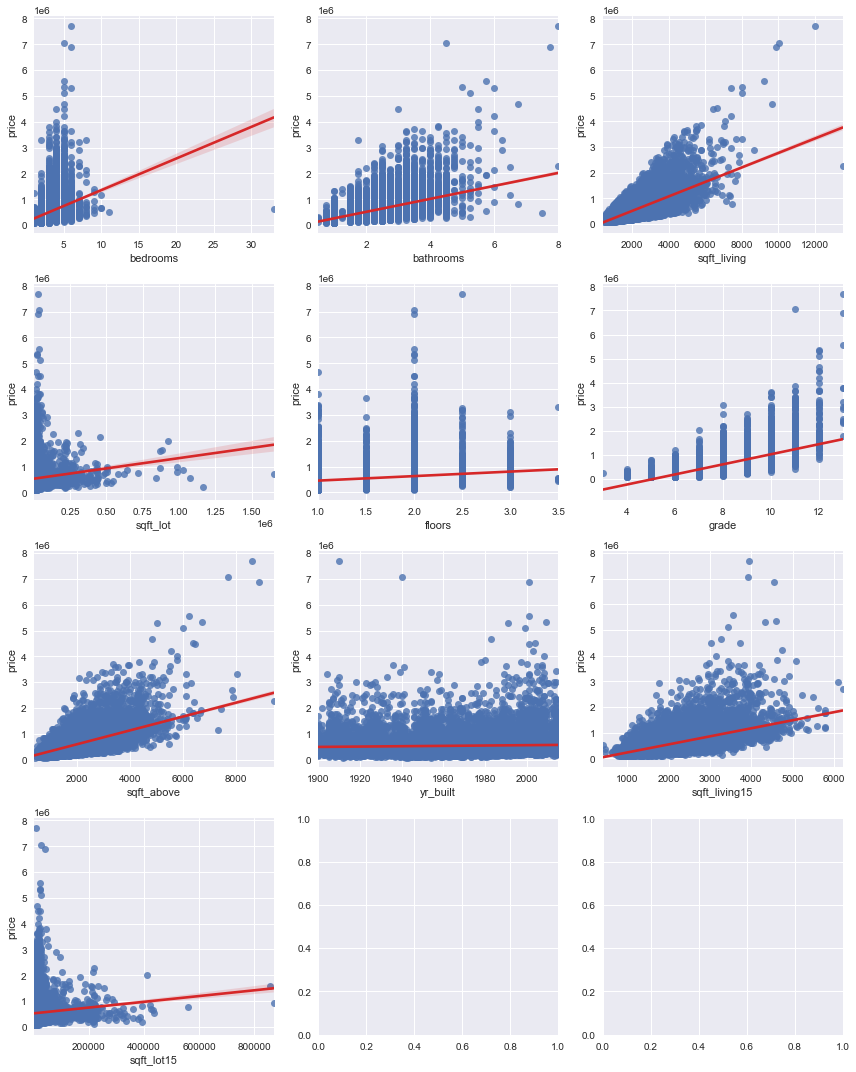

In [47]:
# check continuous features, some maybe catagorical features left in, they are ordinal

#looping over all columns  
plots = cont_df.drop('price', axis=1)

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 15))
fig.set_tight_layout(True)

for index, col in enumerate(plots.columns):
    ax = axes[index//3][index%3]
    sns.regplot(x = col, y = 'price', data = cont_df, ax=ax, line_kws={"color": "tab:red"})
    ax.set_xlabel(col)
    ax.set_ylabel("price")

 ### __NOTES:__
- `'year_built'` is a flat line and has no relationship with `'price'`
- `'floors'` is on the cusp, I will keep for now
- `'bedrooms'`, `'sqft_lot15'`, `'sqft_lot'`, and `'sqft_living'` have obvious outliers


In [48]:
# drop 
cont_df = cont_df.drop('yr_built', axis=1)

#check
cont_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,7,1180,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,7,2170,1690,7639
2,180000.0,2,1.00,770,10000,1.0,6,770,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,7,1050,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,8,1680,1800,7503


In [49]:
# is there really a 30+ bedroom house?
cont_df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [50]:
# drop that 1 it's obviously an anomaly 
cont_df = cont_df[cont_df['bedrooms']<30]

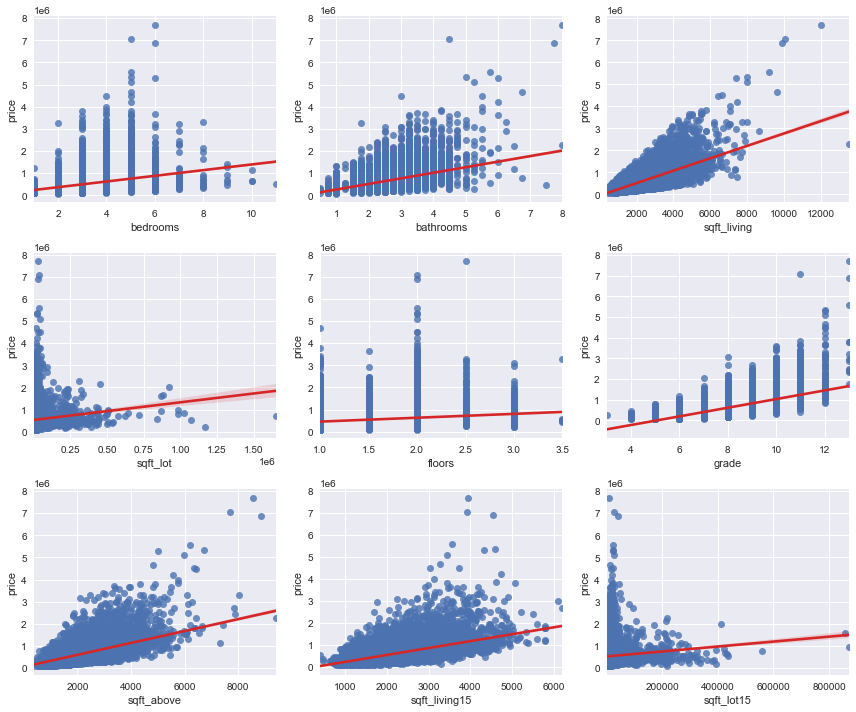

In [51]:
# again, now that 'year_built' have been dropped, and the 33 room house removed
plots = cont_df.drop('price', axis=1)

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 10))
fig.set_tight_layout(True)

for index, col in enumerate(plots.columns):
    ax = axes[index//3][index%3]
    sns.regplot(x = col, y = 'price', data = cont_df, ax=ax, line_kws={"color": "tab:red"})
    ax.set_xlabel(col)
    ax.set_ylabel("price")

# Modeling

## Baseline Model

### Build baseline model with highest correlated feature

In [52]:
# get absolute value of correllations and sort highest to lowest
cont_df.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.701929
grade            0.667964
sqft_above       0.605392
sqft_living15    0.585267
bathrooms        0.525915
bedrooms         0.315961
floors           0.256820
sqft_lot         0.089879
sqft_lot15       0.082849
Name: price, dtype: float64

In [53]:
# use 'sqft_living' as baseline model feature
# baseline model
baseline_model_df = cont_df[['sqft_living', 'price']]

baseline = model(baseline_model_df, target)
baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Tue, 05 Jul 2022   Prob (F-statistic):               0.00
Time:                        13:03:33   Log-Likelihood:            -3.0005e+05
No. Observations:               21596   AIC:                         6.001e+05
Df Residuals:                   21594   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.401e+04   4410.123     -9.980      0.000   -5.27e+04   -3.54e+04
sqft_living   280.8688      1.939    144.820      0.000     277.067     284.670
==============================================================================
Omnibus:                    14801.492   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542642.481
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

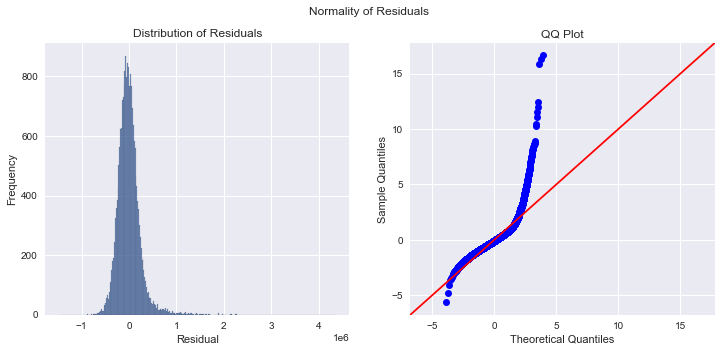

In [54]:
# a look at the residuals
normality_check(baseline_model_df, target)

### __NOTES:__
Clearly there is a problem with the residuals, this is likely due to outliers from the target feature. I will Log transform target to see if the residuals can be more normally distributed.

### Model with log transformed `price_log` as target

In [55]:
cont_df['price']

0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21592    360000.0
21593    400000.0
21594    402101.0
21595    400000.0
21596    325000.0
Name: price, Length: 21596, dtype: float64

In [56]:
# log price and store in new column 'price_log'
cont_df['price_log'] = np.log(cont_df['price'])

In [57]:
# drop 'price' from cont_df
cont_df = cont_df.drop('price', axis=1)

# define new df
base2_model_log = cont_df[['sqft_living', 'price_log']].dropna()

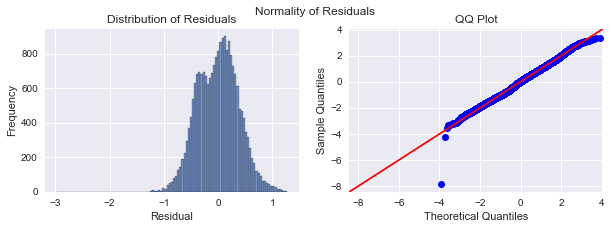

r_sq: 0.48331566140862225. r_sq_adjusted: 0.48329173419094185. k_fold_r: 0.4830740326863596


,coef,std err,t,P>|t|,[0.025,0.975]
const,12.2187,0.006,1915.377,0.000,12.206,12.231
sqft_living,0.0004,2.81e-06,142.125,0.000,0.000,0.000


In [58]:
# redefine target
target = 'price_log'

# model it 
model_it_small(base2_model_log, target)

### __NOTES:__
There is still a couple pretty extreme outliers. I will explore dropping outliers instead of log transform. 

In [59]:
# investigate repercussions of blanket outlier removal from price
all_price = len(data["price"])
no_out = len(remove_outliers(data, "price"))
lost = all_price-no_out

print(f'Price feature currently has {all_price} values.')
print(f'If outliers removed it will have {no_out}.')
print(f'That means {lost} would be removed, or {(round(lost/all_price, 2))*100}% dropped.')

Price feature currently has 21597 values.
If outliers removed it will have 21191.
That means 406 would be removed, or 2.0% dropped.


In [60]:
# drop anything outside of 3 std's
price_3std = remove_outliers(data, "price")
price_3std

,id,season_sold,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,has_basement,Location/Area
0,7129300520,fall,221900.0,3,1.00,1180,5650,1.0,NO,NONE,...,1180,1955,0.0,98178,47.5112,-122.257,1340,5650,NO,Seattle Area
1,6414100192,winter,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,2170,1951,1991.0,98125,47.7210,-122.319,1690,7639,YES,Seattle Area
2,5631500400,winter,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,770,1933,NaN,98028,47.7379,-122.233,2720,8062,NO,Bothell Area
3,2487200875,winter,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1050,1965,0.0,98136,47.5208,-122.393,1360,5000,YES,Seattle Area
4,1954400510,winter,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1680,1987,0.0,98074,47.6168,-122.045,1800,7503,NO,Sammamish Area
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,spring,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,1530,2009,0.0,98103,47.6993,-122.346,1530,1509,NO,Seattle Area
21593,6600060120,winter,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,2310,2014,0.0,98146,47.5107,-122.362,1830,7200,NO,Seattle Area
21594,1523300141,summer,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,1020,2009,0.0,98144,47.5944,-122.299,1020,2007,NO,Seattle Area
21595,291310100,winter,400000.0,3,2.50,1600,2388,2.0,NO,NONE,...,1600,2004,0.0,98027,47.5345,-122.069,1410,1287,NO,Sammamish Area


### Model with outliers removed from `price` (INSTEAD of log transforming)

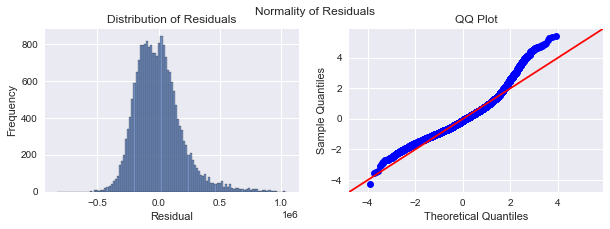

r_sq: 0.441701214930702. r_sq_adjusted: 0.441674866410948. k_fold_r: 0.44127863369031955


,coef,std err,t,P>|t|,[0.025,0.975]
const,8.814e+04,3498.528,25.194,0.000,8.13e+04,9.5e+04
sqft_living,206.0861,1.592,129.475,0.000,202.966,209.206


In [61]:
# model with outliers removed INSTEAD of log transforming
price_3std_model = price_3std[['price', 'sqft_living']]
model_it_small(price_3std_model, 'price')

### __NOTES:__
Log transformation did a better job of normalizing residuals but it had a couple extreme outliers. At this point I can either stick with the outlier removed df (`price_3std`) as it is, I can try log transforming it, or I can try removing outliers from log transformed `cont_df['price_log']`.
 

In [62]:
# explore what would happen if outliers removed form log transformed df
no_out_log = len(remove_outliers(cont_df, target))
removed = all_price - no_out_log

print(f'If outliers removed from log transformed data there will be {no_out_log} data points remaining.')
print(f'Thats {no_out_log - no_out} more than removing outliers from raw data,')
print(f'this would result in {(round(removed/all_price, 2))*100}% of data being removed rather than 2%.')

If outliers removed from log transformed data there will be 21427 data points remaining.
Thats 236 more than removing outliers from raw data,
this would result in 1.0% of data being removed rather than 2%.


### __NOTES:__
I have decided to preserve as much data as possible and I will remove outliers from my logged data (`cont_df['price_log']`).

### Model removing outliers from `cont_df['price_log']`

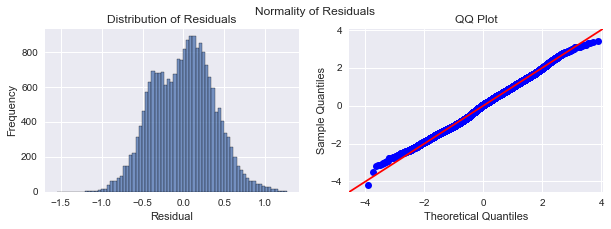

r_sq: 0.4517919301514499. r_sq_adjusted: 0.4517663428436389. k_fold_r: 0.4517066812587575


,coef,std err,t,P>|t|,[0.025,0.975]
const,12.2369,0.007,1871.209,0.000,12.224,12.250
sqft_living,0.0004,2.92e-06,132.879,0.000,0.000,0.000


In [63]:
# remove 3 std from mean
log_3std = remove_outliers(cont_df, target)

# get only highest correlated feature and target
model_log_3std = log_3std[['sqft_living', target]]

# model
model_it_small(model_log_3std, target)

### **NOTES:**
removing outliers 3 std's from mean got rid of the extreme outliers that were skewing the distribution of the residuals.

## Moving beyond baseline model

### Model bringing in the remaining continuous features

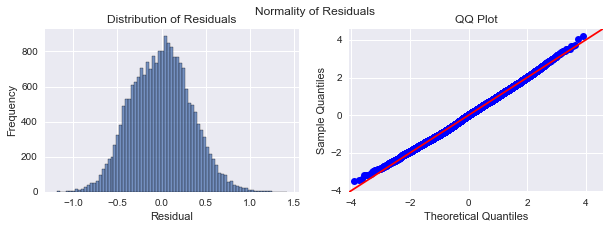

r_sq: 0.5456519988639987. r_sq_adjusted: 0.5454610696017199. k_fold_r: 0.5451343492267143


,coef,std err,t,P>|t|,[0.025,0.975]
const,11.1970,0.021,522.087,0.000,11.155,11.239
bedrooms,-0.0212,0.003,-6.323,0.000,-0.028,-0.015
bathrooms,-0.0260,0.005,-5.004,0.000,-0.036,-0.016
sqft_living,0.0003,7.26e-06,43.616,0.000,0.000,0.000
sqft_lot,3.227e-07,8.05e-08,4.008,0.000,1.65e-07,4.81e-07
floors,0.0654,0.006,11.127,0.000,0.054,0.077
grade,0.1749,0.004,49.522,0.000,0.168,0.182
sqft_above,-0.0002,7.03e-06,-25.683,0.000,-0.000,-0.000
sqft_living15,0.0001,5.72e-06,18.170,0.000,9.26e-05,0.000
sqft_lot15,-7.591e-07,1.23e-07,-6.169,0.000,-1e-06,-5.18e-07


In [64]:
model_it_small(log_3std, target)

### **NOTES:**
All the p values are less than .05, this is great. The distribution of the residuals so far looks amazing but the r squared shows this model only accounts for 54% of the variability observed in Sale Price. Adding features to boost the r squared value is needed.

## Moving beyond continuous features
First I will model each feature added individually to current model_df (log_3std) to see how they each impact residuals

In [65]:
# define the different features

season_cols = [col for col in dummies_df.columns if 'season' in col]

basement_col = [col for col in dummies_df.columns if 'basement' in col]

condition_cols = [col for col in dummies_df.columns if 'condition' in col]

location_cols = [col for col in dummies_df.columns if 'Location' in col]

view_cols = [col for col in dummies_df.columns if 'view' in col]

waterfront_col  = [col for col in dummies_df if 'waterfront' in col]

-----------------------------------------------------------------------------
ADDED: ['season_sold_spring', 'season_sold_summer', 'season_sold_winter']


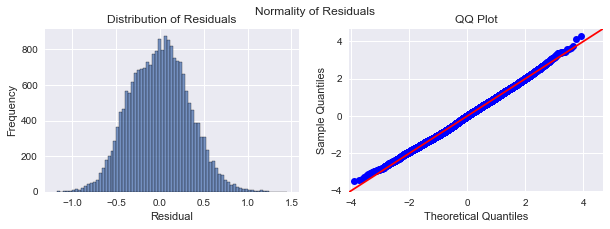

r_sq: 0.5475540244201814. r_sq_adjusted: 0.5473004822651913. k_fold_r: 0.5468813575900148
-----------------------------------------------------------------------------

-----------------------------------------------------------------------------
ADDED: ['has_basement_YES']


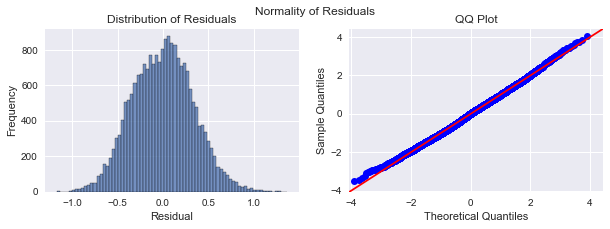

r_sq: 0.5503655745677315. r_sq_adjusted: 0.5501556219970216. k_fold_r: 0.549850990348001
-----------------------------------------------------------------------------

-----------------------------------------------------------------------------
ADDED: ['condition_Fair', 'condition_Good', 'condition_Poor', 'condition_Very Good']


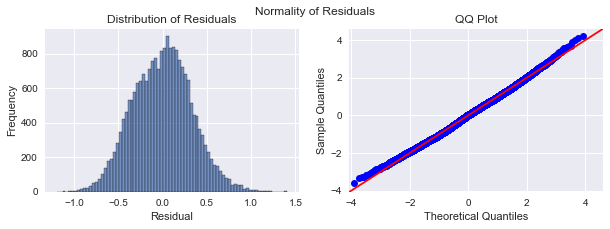

r_sq: 0.5604338113837831. r_sq_adjusted: 0.5601669473081277. k_fold_r: 0.5596920297042999
-----------------------------------------------------------------------------

-----------------------------------------------------------------------------
ADDED: ['Location/Area_Bellevue Area', 'Location/Area_Black Diamond', 'Location/Area_Bothell Area', 'Location/Area_Carnation', 'Location/Area_Duvall', 'Location/Area_Enumclaw', 'Location/Area_Fall City', 'Location/Area_Kent Area', 'Location/Area_Maple Valley', 'Location/Area_Medina', 'Location/Area_Mercer Island', 'Location/Area_Newcastle Area', 'Location/Area_North Bend', 'Location/Area_Sammamish Area', 'Location/Area_Seattle Area', 'Location/Area_Snoqualmie', 'Location/Area_Vashon', 'Location/Area_Woodinville']


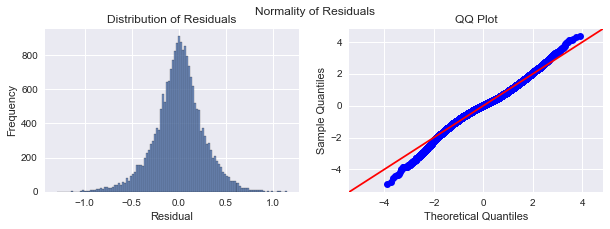

r_sq: 0.7267941632415724. r_sq_adjusted: 0.7264494481804724. k_fold_r: 0.7261027055412711
-----------------------------------------------------------------------------

-----------------------------------------------------------------------------
ADDED: ['view_EXCELLENT', 'view_FAIR', 'view_GOOD', 'view_NONE']


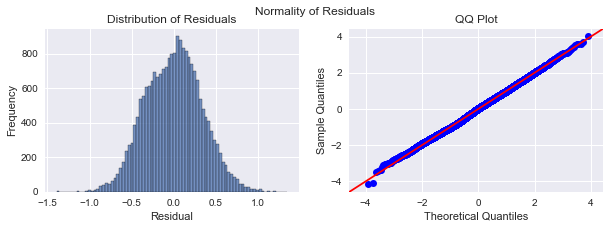

r_sq: 0.558959831876068. r_sq_adjusted: 0.5586920729359097. k_fold_r: 0.5582310482238132
-----------------------------------------------------------------------------

-----------------------------------------------------------------------------
ADDED: ['waterfront_YES']


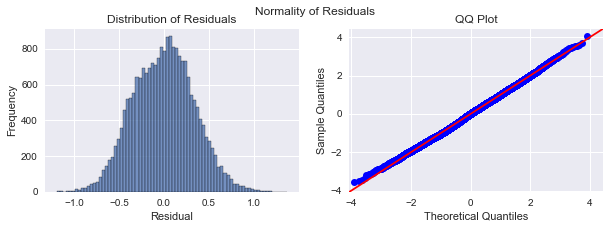

r_sq: 0.55166779392804. r_sq_adjusted: 0.5514584494164263. k_fold_r: 0.5511245593881987
-----------------------------------------------------------------------------



In [66]:
# model each, individually added to log_3std
model_these = [season_cols, basement_col, condition_cols, location_cols, view_cols, waterfront_col]

current_model = log_3std

for feature in model_these:
    
    features_to_add = dummies_df[feature]

    expanded_model = pd.concat([current_model, features_to_add], axis=1).dropna(axis=0)
    
    print('-----------------------------------------------------------------------------')
    print(f'ADDED: {feature}')
    model_it_small(expanded_model, target)
    print('-----------------------------------------------------------------------------')
    print()



### NOTES:
Location boosts r squared the most (no surprise, it is the largest) but has the worst distribution of residuals. I will add this feature last. May need to perform additional or different transformations to it.

### Model: add categorical features EXCEPT 'Location/Area'

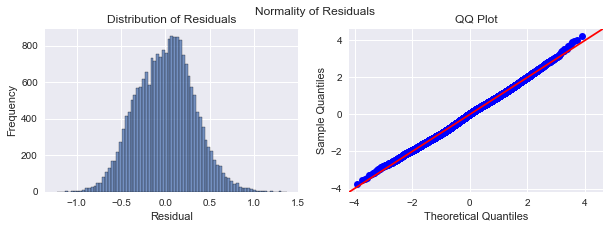

r_sq: 0.5819262286810336. r_sq_adjusted: 0.5814965135357795. k_fold_r: 0.5808586755200402


,coef,std err,t,P>|t|,[0.025,0.975]
const,11.2371,0.025,455.375,0.000,11.189,11.285
bedrooms,-0.0160,0.003,-4.934,0.000,-0.022,-0.010
bathrooms,-0.0267,0.005,-5.311,0.000,-0.037,-0.017
sqft_living,0.0001,1.01e-05,13.736,0.000,0.000,0.000
sqft_lot,2.985e-07,7.74e-08,3.857,0.000,1.47e-07,4.5e-07
floors,0.0826,0.006,14.422,0.000,0.071,0.094
grade,0.1704,0.003,49.770,0.000,0.164,0.177
sqft_above,1.626e-05,1.09e-05,1.490,0.136,-5.14e-06,3.77e-05
sqft_living15,9.205e-05,5.54e-06,16.610,0.000,8.12e-05,0.000
sqft_lot15,-7.397e-07,1.18e-07,-6.259,0.000,-9.71e-07,-5.08e-07


In [67]:
# define the current/most recent
current_model = log_3std

# remove 'Location/Area' features from dummies_df
features_to_add = dummies_df.drop(location_cols, axis=1)

# define new df with added features
expanded_model = pd.concat([current_model, features_to_add], axis=1).dropna(axis=0)

# model it
model_it_small(expanded_model, target)

### NOTES:
qq-plot looks great. Some features have p-values above .05

### High p_value notes:
- `'season_sold_summer'` and `'season_sold_winter'`
 - Removing these will turn 'season_sold' into boolean, essentially becoming "sold_in_spring_YES"
- `'condition_Poor'` and `'view_Good'` 
 - deleting these will pose problems with final comparision to deleted get_dummies variable. Unlike the above there is no easy way to drop and regroup feature. For example, for `'condition_Poor'` I will need to also delete `'condition_Fair'` so the remaining feature coefficients will show changes in comparison to "condtion_Average_and_below" 
 - Alternativly: I could remove these from dummies_df and, because these values are ordinal rankings, I can convert them to int rankings; Turning final interpretations into "for each increase in condition/view rating, sale price is impacted in this way"
- `'sqft_above'` balloned to .136, I will address this after re working categorical features. 

# Reworking Categorical Features

### Drop categorical features, from current `dummies_df`, that will become ordinal

In [68]:
# define categorical features to be converted to continuous
cat_to_ordinal = [col for col in dummies_df.columns if ('condition' in col)|('view' in col)]

# drop these columns from dummies_df
new_dummies_df = dummies_df.drop(cat_to_ordinal, axis=1)

#check
new_dummies_df

,has_basement_YES,waterfront_YES,season_sold_spring,season_sold_summer,season_sold_winter,Location/Area_Bellevue Area,Location/Area_Black Diamond,Location/Area_Bothell Area,Location/Area_Carnation,Location/Area_Duvall,...,Location/Area_Maple Valley,Location/Area_Medina,Location/Area_Mercer Island,Location/Area_Newcastle Area,Location/Area_North Bend,Location/Area_Sammamish Area,Location/Area_Seattle Area,Location/Area_Snoqualmie,Location/Area_Vashon,Location/Area_Woodinville
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21593,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21594,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21595,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Convert dropped cateoricals to integers so they become ordinal

In [69]:
# df of original condition and view columns
condition_view_df = data[['condition', 'view']]

# view the values again
for column in condition_view_df.columns:
    print(f"COLUMN: '{column}'")
    print(f"Number of unique values: {len(condition_view_df[column].unique())}")
    print(condition_view_df[column].value_counts())
    print()

COLUMN: 'condition'
Number of unique values: 5
Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

COLUMN: 'view'
Number of unique values: 5
NONE         19485
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64



In [70]:
# make dictionaries for both features, values ranking in order of lowest to highest

condition_conversion_dict = {'Poor':1, 'Fair':2, 'Average':3, 'Good': 4, 'Very Good':5}
view_conversion_dict = {'NONE':0, 'FAIR':1, 'AVERAGE':2, 'GOOD': 3, 'EXCELLENT':4}

In [71]:
# use dictinaries to replace value in condition_view_df

condition_view_df['condition'] = condition_view_df['condition'].replace(condition_conversion_dict)
condition_view_df['view'] = condition_view_df['view'].replace(view_conversion_dict)

# check
condition_view_df

<ipython-input-71-dea4b6972a97>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_view_df['condition'] = condition_view_df['condition'].replace(condition_conversion_dict)
<ipython-input-71-dea4b6972a97>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_view_df['view'] = condition_view_df['view'].replace(view_conversion_dict)


,condition,view
0,3,0
1,3,0
2,3,0
3,5,0
4,3,0
...,...,...
21592,3,0
21593,3,0
21594,3,0
21595,3,0


### Plot new ordinal features , `condition_view_df`, to check for linear relationship with price

In [72]:
# add, logged & outliers-removed, price: 
condition_view_df['price_log'] = log_3std['price_log']

#check
condition_view_df

<ipython-input-72-c61853aa69cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_view_df['price_log'] = log_3std['price_log']


,condition,view,price_log
0,3,0,12.309982
1,3,0,13.195614
2,3,0,12.100712
3,5,0,13.311329
4,3,0,13.142166
...,...,...,...
21592,3,0,12.793859
21593,3,0,12.899220
21594,3,0,12.904459
21595,3,0,12.899220


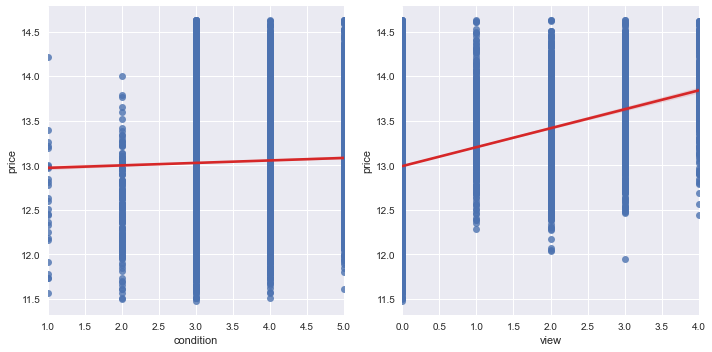

In [73]:
# plot these two new ordinal features
new_ordinal_features = condition_view_df.drop(target, axis=1)

fig, axes = plt.subplots(1,2, figsize=(10, 5))
fig.set_tight_layout(True)

for index, col in enumerate(new_ordinal_features.columns):
    ax = axes[index]
    sns.regplot(x = col, y = target , data = condition_view_df, ax=ax, line_kws={"color": "tab:red"})
    ax.set_xlabel(col)
    ax.set_ylabel("price")

### NOTES: `'condition'` is *barely* linear but there is something there so I will keep for now and see how coefficent turns out

# Modeling (cont.)

## Remodel with new continuous (and ordinal) features only

### Add `new_ordinal_features` to current continuous df , `log_3std`, and model

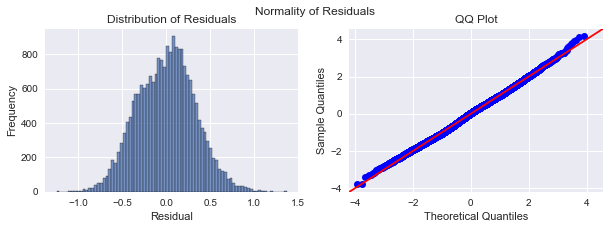

r_sq: 0.5703067195360323. r_sq_adjusted: 0.5700860038654694. k_fold_r: 0.5697515866228674


,coef,std err,t,P>|t|,[0.025,0.975]
const,10.8620,0.025,426.471,0.000,10.812,10.912
bedrooms,-0.0190,0.003,-5.815,0.000,-0.025,-0.013
bathrooms,-0.0172,0.005,-3.389,0.001,-0.027,-0.007
sqft_living,0.0003,7.25e-06,36.325,0.000,0.000,0.000
sqft_lot,2.85e-07,7.83e-08,3.638,0.000,1.31e-07,4.39e-07
floors,0.0834,0.006,14.436,0.000,0.072,0.095
grade,0.1743,0.003,50.609,0.000,0.168,0.181
sqft_above,-0.0001,7.01e-06,-18.655,0.000,-0.000,-0.000
sqft_living15,9.16e-05,5.61e-06,16.342,0.000,8.06e-05,0.000
sqft_lot15,-7.83e-07,1.2e-07,-6.543,0.000,-1.02e-06,-5.48e-07


In [74]:
# add new_ordinal_features to log_3std
ordinal_and_cont_df = pd.concat([log_3std, new_ordinal_features], axis=1).dropna(axis=0)

model_it_small(ordinal_and_cont_df, target)

### NOTES:
The P-values look good again. I will repeat above experiment of adding all categoricals EXCEPT location

## Remodel with new categorical features (except `'Location/Area'`)

### Add categorical features EXCEPT `'Location/Area'` 

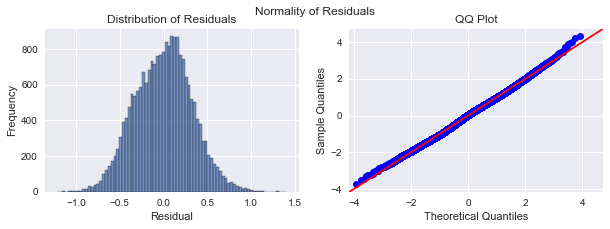

r_sq: 0.580204384244089. r_sq_adjusted: 0.5798906649609459. k_fold_r: 0.5795292551751744


,coef,std err,t,P>|t|,[0.025,0.975]
const,10.8183,0.026,423.923,0.000,10.768,10.868
bedrooms,-0.0169,0.003,-5.209,0.000,-0.023,-0.011
bathrooms,-0.0258,0.005,-5.125,0.000,-0.036,-0.016
sqft_living,0.0001,1.01e-05,13.917,0.000,0.000,0.000
sqft_lot,2.929e-07,7.75e-08,3.781,0.000,1.41e-07,4.45e-07
floors,0.0840,0.006,14.718,0.000,0.073,0.095
grade,0.1695,0.003,49.588,0.000,0.163,0.176
sqft_above,1.461e-05,1.09e-05,1.336,0.181,-6.82e-06,3.6e-05
sqft_living15,9.355e-05,5.54e-06,16.875,0.000,8.27e-05,0.000
sqft_lot15,-7.657e-07,1.18e-07,-6.468,0.000,-9.98e-07,-5.34e-07


In [75]:
# define current model
current_model = ordinal_and_cont_df

# add new_dummies_df minus the location/area features
features_to_add = new_dummies_df.drop(location_cols, axis=1)

# define new df with added features
expanded_model = pd.concat([current_model, features_to_add], axis=1).dropna(axis=0)

# model it 
model_it_small(expanded_model, target)

### NOTES:
Similar to before, high p-values
- `'season_sold_summer'` and `'season_sold_winter'`
 - Removing these will turn 'season_sold' into boolean, essentially becoming "sold_in_spring_YES"
- `'sqft_above'` I will drop this feature. It is likely highly correlated with `'sqft_living'` anyway

### Model: drop `'season_sold_summer'` & `'season_sold_winter'`

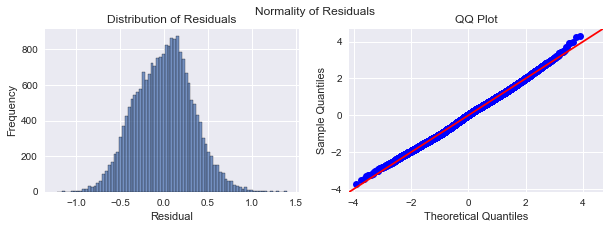

r_sq: 0.5800853808261619. r_sq_adjusted: 0.5798108242845762. k_fold_r: 0.5795440846756139


,coef,std err,t,P>|t|,[0.025,0.975]
const,10.8152,0.025,427.695,0.000,10.766,10.865
bedrooms,-0.0170,0.003,-5.237,0.000,-0.023,-0.011
bathrooms,-0.0257,0.005,-5.113,0.000,-0.036,-0.016
sqft_living,0.0001,1.01e-05,13.910,0.000,0.000,0.000
sqft_lot,2.898e-07,7.75e-08,3.741,0.000,1.38e-07,4.42e-07
floors,0.0843,0.006,14.760,0.000,0.073,0.095
grade,0.1696,0.003,49.615,0.000,0.163,0.176
sqft_above,1.456e-05,1.09e-05,1.332,0.183,-6.87e-06,3.6e-05
sqft_living15,9.376e-05,5.54e-06,16.915,0.000,8.29e-05,0.000
sqft_lot15,-7.621e-07,1.18e-07,-6.439,0.000,-9.94e-07,-5.3e-07


In [76]:
# drop high p-value 'season' features
updated_model = expanded_model.drop(['season_sold_summer', 'season_sold_winter'], axis=1)

# model it 
model_it_small(updated_model, target)

### NOTES:
Looking great. Still need to drop `'sqft_above'`

### Model: drop `'sqft_above'`

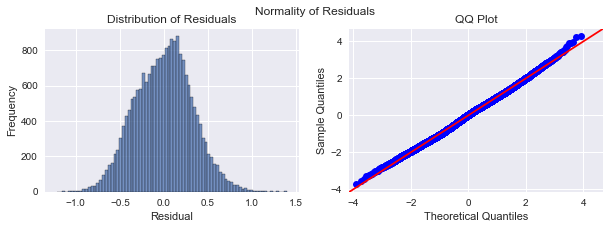

r_sq: 0.5800505940789942. r_sq_adjusted: 0.5797956395057455. k_fold_r: 0.5795162314886239


,coef,std err,t,P>|t|,[0.025,0.975]
const,10.8138,0.025,427.987,0.000,10.764,10.863
bedrooms,-0.0171,0.003,-5.270,0.000,-0.023,-0.011
bathrooms,-0.0258,0.005,-5.133,0.000,-0.036,-0.016
sqft_living,0.0002,5.73e-06,26.490,0.000,0.000,0.000
sqft_lot,2.935e-07,7.74e-08,3.792,0.000,1.42e-07,4.45e-07
floors,0.0864,0.005,15.733,0.000,0.076,0.097
grade,0.1702,0.003,50.270,0.000,0.164,0.177
sqft_living15,9.47e-05,5.5e-06,17.220,0.000,8.39e-05,0.000
sqft_lot15,-7.605e-07,1.18e-07,-6.425,0.000,-9.93e-07,-5.29e-07
condition,0.0966,0.004,26.856,0.000,0.090,0.104


In [77]:
# drop high p-value 'sqft_above'
final_drop_before_adding_locations = updated_model.drop('sqft_above', axis=1)

# model it 
model_it_small(final_drop_before_adding_locations, target)

### NOTES:
Oh my Dog its gorgeous. Now just need to figure out a way to work in Location feature

## Model: add in `'Location/Area'` features as they currently stand 

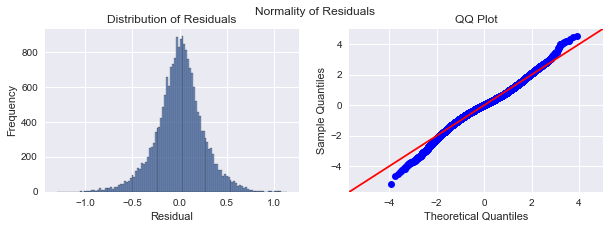

r_sq: 0.7501703894358839. r_sq_adjusted: 0.7498084021525239. k_fold_r: 0.7494748346905405


,coef,std err,t,P>|t|,[0.025,0.975]
const,10.6229,0.021,511.950,0.000,10.582,10.664
bedrooms,-0.0092,0.003,-3.646,0.000,-0.014,-0.004
bathrooms,0.0195,0.004,4.935,0.000,0.012,0.027
sqft_living,0.0002,4.43e-06,35.066,0.000,0.000,0.000
sqft_lot,5.937e-07,6.01e-08,9.880,0.000,4.76e-07,7.12e-07
floors,0.0649,0.004,14.919,0.000,0.056,0.073
grade,0.1291,0.003,48.298,0.000,0.124,0.134
sqft_living15,0.0001,4.48e-06,22.626,0.000,9.25e-05,0.000
sqft_lot15,-1.99e-07,9.41e-08,-2.115,0.034,-3.83e-07,-1.46e-08
condition,0.0894,0.003,31.791,0.000,0.084,0.095


In [78]:
# define current model
current_model = final_drop_before_adding_locations

# add the new_dummies_df location features
features_to_add = new_dummies_df[location_cols]

# define new df with added features
everything_model = pd.concat([current_model, features_to_add], axis=1).dropna(axis=0)

# model it 
model_it_small(everything_model, target)

### NOTES:
Nope, I do not like this. I will consider my last successful model to be: 'final_drop_before_adding_locations'


I will rework location, originally `data['zipcode']`, then add to 'final_drop_before_adding_locations' and re model


# Reworking `data['zipcode']`
As it currently stands, the zipcodes have been converted to Location/Areas, I did not like the way that affected the model so I will try a different approach. I will try dividing locations into 'Urban' and 'Rural' based on population and population density.


## Add  `'population'` & `'population_density'` columns

### Population & Population Density by zipcode from: 
https://standardcode.s3.amazonaws.com/documents/us_population_density_by_zip_september2020.csv

Extract relevant information for just Washington State

In [79]:
population_df = pd.read_csv('https://standardcode.s3.amazonaws.com/documents/us_population_density_by_zip_september2020.csv')

# Define Washington only (there is a space in front of Washington)
Washington = population_df[population_df['state']== ' Washington']

# check
Washington

,zip,population,population_density,city,state,latitude,longitude
49,98174,180,50978.44,Seattle,Washington,47.6046,-122.3354
249,98121,8558,17894.56,Seattle,Washington,47.6147,-122.3459
266,98104,13095,17156.75,Seattle,Washington,47.6017,-122.3277
284,98101,9010,16603.32,Seattle,Washington,47.6102,-122.3346
341,98102,19424,14594.02,Seattle,Washington,47.6344,-122.3216
...,...,...,...,...,...,...,...
31113,99146,44,1.18,Laurier,Washington,48.9573,-118.2804
31133,99356,175,1.15,Roosevelt,Washington,45.8457,-120.2840
31380,98283,378,0.70,Rockport,Washington,48.7314,-121.4725
31381,99105,57,0.69,Benge,Washington,46.8703,-118.0800


In [80]:
# I only need 'zip', 'population', and 'population_density'
Wash = Washington[['zip', 'population', 'population_density']]

# Rename zip to zipcode to match data df
Wash.rename(columns={'zip': 'zipcode'}, inplace=True)

#check
Wash

/Users/me/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,zipcode,population,population_density
49,98174,180,50978.44
249,98121,8558,17894.56
266,98104,13095,17156.75
284,98101,9010,16603.32
341,98102,19424,14594.02
...,...,...,...
31113,99146,44,1.18
31133,99356,175,1.15
31380,98283,378,0.70
31381,99105,57,0.69


### Add 'zipcode' column onto current working model df

In [81]:
# define current model df 
current_working_df = final_drop_before_adding_locations

# add 'zipcode' column to this df
current_working_df['zipcode'] = data['zipcode']

#check
current_working_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_living15,sqft_lot15,price_log,condition,view,has_basement_YES,waterfront_YES,season_sold_spring,zipcode
0,3.0,1.00,1180.0,5650.0,1.0,7.0,1340.0,5650.0,12.309982,3.0,0.0,0,0,0,98178
1,3.0,2.25,2570.0,7242.0,2.0,7.0,1690.0,7639.0,13.195614,3.0,0.0,1,0,0,98125
2,2.0,1.00,770.0,10000.0,1.0,6.0,2720.0,8062.0,12.100712,3.0,0.0,0,0,0,98028
3,4.0,3.00,1960.0,5000.0,1.0,7.0,1360.0,5000.0,13.311329,5.0,0.0,1,0,0,98136
4,3.0,2.00,1680.0,8080.0,1.0,8.0,1800.0,7503.0,13.142166,3.0,0.0,0,0,0,98074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3.0,2.50,1530.0,1131.0,3.0,8.0,1530.0,1509.0,12.793859,3.0,0.0,0,0,1,98103
21593,4.0,2.50,2310.0,5813.0,2.0,8.0,1830.0,7200.0,12.899220,3.0,0.0,0,0,0,98146
21594,2.0,0.75,1020.0,1350.0,2.0,7.0,1020.0,2007.0,12.904459,3.0,0.0,0,0,0,98144
21595,3.0,2.50,1600.0,2388.0,2.0,8.0,1410.0,1287.0,12.899220,3.0,0.0,0,0,0,98027


### Investigate repercussions of inner merge

In [82]:
# check the length before merging
len(current_working_df)

21427

In [83]:
# check length if 'inner' merge
len(current_working_df.merge(Wash, how='inner', on='zipcode'))

20178

In [84]:
# how many lost?
21427-20178

1249

In [85]:
f'{round((1249/21427)*100,2)}%'

'5.83%'

### NOTES:
If I do an 'inner' merge I will lose 1,249 data points, thats 5.83%. Too much for me to be comfortable. I will do a 'left' merge and try to see what is missing. Maybe only a few zipcodes I can look up by hand

### Do left merge instead of inner. 

In [86]:
# try left merge and see what zipcodes were not assigned population density,
# maybe it is enough to look up seperately
Left = current_working_df.merge(Wash, how='left', on='zipcode')
Left

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_living15,sqft_lot15,price_log,condition,view,has_basement_YES,waterfront_YES,season_sold_spring,zipcode,population,population_density
0,3.0,1.00,1180.0,5650.0,1.0,7.0,1340.0,5650.0,12.309982,3.0,0.0,0,0,0,98178,21860.0,4386.27
1,3.0,2.25,2570.0,7242.0,2.0,7.0,1690.0,7639.0,13.195614,3.0,0.0,1,0,0,98125,34994.0,6476.98
2,2.0,1.00,770.0,10000.0,1.0,6.0,2720.0,8062.0,12.100712,3.0,0.0,0,0,0,98028,18165.0,3329.05
3,4.0,3.00,1960.0,5000.0,1.0,7.0,1360.0,5000.0,13.311329,5.0,0.0,1,0,0,98136,14138.0,6132.32
4,3.0,2.00,1680.0,8080.0,1.0,8.0,1800.0,7503.0,13.142166,3.0,0.0,0,0,0,98074,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21422,3.0,2.50,1530.0,1131.0,3.0,8.0,1530.0,1509.0,12.793859,3.0,0.0,0,0,1,98103,41971.0,8324.30
21423,4.0,2.50,2310.0,5813.0,2.0,8.0,1830.0,7200.0,12.899220,3.0,0.0,0,0,0,98146,25574.0,5745.23
21424,2.0,0.75,1020.0,1350.0,2.0,7.0,1020.0,2007.0,12.904459,3.0,0.0,0,0,0,98144,24913.0,7365.11
21425,3.0,2.50,1600.0,2388.0,2.0,8.0,1410.0,1287.0,12.899220,3.0,0.0,0,0,0,98027,22219.0,423.04


In [87]:
# fill the null values with zero so we can extract out the associated zipcode
Left['population'] = Left['population'].fillna(0.0)

# check
Left

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_living15,sqft_lot15,price_log,condition,view,has_basement_YES,waterfront_YES,season_sold_spring,zipcode,population,population_density
0,3.0,1.00,1180.0,5650.0,1.0,7.0,1340.0,5650.0,12.309982,3.0,0.0,0,0,0,98178,21860.0,4386.27
1,3.0,2.25,2570.0,7242.0,2.0,7.0,1690.0,7639.0,13.195614,3.0,0.0,1,0,0,98125,34994.0,6476.98
2,2.0,1.00,770.0,10000.0,1.0,6.0,2720.0,8062.0,12.100712,3.0,0.0,0,0,0,98028,18165.0,3329.05
3,4.0,3.00,1960.0,5000.0,1.0,7.0,1360.0,5000.0,13.311329,5.0,0.0,1,0,0,98136,14138.0,6132.32
4,3.0,2.00,1680.0,8080.0,1.0,8.0,1800.0,7503.0,13.142166,3.0,0.0,0,0,0,98074,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21422,3.0,2.50,1530.0,1131.0,3.0,8.0,1530.0,1509.0,12.793859,3.0,0.0,0,0,1,98103,41971.0,8324.30
21423,4.0,2.50,2310.0,5813.0,2.0,8.0,1830.0,7200.0,12.899220,3.0,0.0,0,0,0,98146,25574.0,5745.23
21424,2.0,0.75,1020.0,1350.0,2.0,7.0,1020.0,2007.0,12.904459,3.0,0.0,0,0,0,98144,24913.0,7365.11
21425,3.0,2.50,1600.0,2388.0,2.0,8.0,1410.0,1287.0,12.899220,3.0,0.0,0,0,0,98027,22219.0,423.04


In [88]:
# if population is equal to zero then append the zipcode to list
need_info = []
i = 0
for row in Left['population']:
    if row == 0.0:
        need_info.append(Left['zipcode'][i])
        i+=1
    else: 
        i+=1

# get unique zipcodes that need a population and population density
set(need_info)

{98030, 98074, 98075, 98077}

### NOTES:
Well look at that. Only 4 zipcodes `{98030, 98074, 98075, 98077}` are missing. I will look these up and replace with appropiate values. 

**INFORMATION FROM** https://www.unitedstateszipcodes.org/98178/ :
- **98030**
 - population: 33,769
 - population_density: 4,741
- **98074**
 - population: 25,748
 - population_density: 2,411
- **98075**
 - population: 20,715
 - population_density: 2,185
- **98077**
 - population: 13,585
 - population_density: 785

### Add missing information

In [89]:
# make two new lists to replace 'population' and 'population_density'
new_population = []
new_population_density = []

i=0
for code in Left['zipcode']:
    if code == 98030:
        new_population.append(33769)
        new_population_density.append(4741)
        i+=1
    elif code == 98074:
        new_population.append(25748)
        new_population_density.append(2411)
        i+=1  
    elif code == 98075:
        new_population.append(20715)
        new_population_density.append(2185)
        i+=1 
    elif code == 98077:
        new_population.append(13585)
        new_population_density.append(785)
        i+=1     
    else: 
        new_population.append(Left['population'][i])
        new_population_density.append(Left['population_density'][i])
        i+=1     

In [90]:
# replace columns values with lists made above
Left['population'] = new_population
Left['population_density'] = new_population_density

#check
Left

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_living15,sqft_lot15,price_log,condition,view,has_basement_YES,waterfront_YES,season_sold_spring,zipcode,population,population_density
0,3.0,1.00,1180.0,5650.0,1.0,7.0,1340.0,5650.0,12.309982,3.0,0.0,0,0,0,98178,21860.0,4386.27
1,3.0,2.25,2570.0,7242.0,2.0,7.0,1690.0,7639.0,13.195614,3.0,0.0,1,0,0,98125,34994.0,6476.98
2,2.0,1.00,770.0,10000.0,1.0,6.0,2720.0,8062.0,12.100712,3.0,0.0,0,0,0,98028,18165.0,3329.05
3,4.0,3.00,1960.0,5000.0,1.0,7.0,1360.0,5000.0,13.311329,5.0,0.0,1,0,0,98136,14138.0,6132.32
4,3.0,2.00,1680.0,8080.0,1.0,8.0,1800.0,7503.0,13.142166,3.0,0.0,0,0,0,98074,25748.0,2411.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21422,3.0,2.50,1530.0,1131.0,3.0,8.0,1530.0,1509.0,12.793859,3.0,0.0,0,0,1,98103,41971.0,8324.30
21423,4.0,2.50,2310.0,5813.0,2.0,8.0,1830.0,7200.0,12.899220,3.0,0.0,0,0,0,98146,25574.0,5745.23
21424,2.0,0.75,1020.0,1350.0,2.0,7.0,1020.0,2007.0,12.904459,3.0,0.0,0,0,0,98144,24913.0,7365.11
21425,3.0,2.50,1600.0,2388.0,2.0,8.0,1410.0,1287.0,12.899220,3.0,0.0,0,0,0,98027,22219.0,423.04


## Use `'population'` & `'population_density'` columns to assign 'Rural' or 'Urban'

According to [USDA.gov](https://www.ers.usda.gov/topics/rural-economy-population/rural-classifications/what-is-rural.aspx), 
> **"rural areas consist of open countryside with population densities less than 500 people per square mile and places with fewer than 2,500 people."**

### Make list of Rural or Urban assignments

In [91]:
Rural_Urban = []
i=0
for row in Left['population']:
    if (Left['population'][i] < 2500)|(Left['population_density'][i] < 500):
        Rural_Urban.append(0)
        i+=1
    else:
        Rural_Urban.append(1)
        i+=1

### Add new column`'population_type_URBAN'` to `Left` and use`Rural_Urban` list to populate values (no pun intented)

In [92]:
Left['population_type_URBAN'] = Rural_Urban

# check 
Left

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_living15,sqft_lot15,price_log,condition,view,has_basement_YES,waterfront_YES,season_sold_spring,zipcode,population,population_density,population_type_URBAN
0,3.0,1.00,1180.0,5650.0,1.0,7.0,1340.0,5650.0,12.309982,3.0,0.0,0,0,0,98178,21860.0,4386.27,1
1,3.0,2.25,2570.0,7242.0,2.0,7.0,1690.0,7639.0,13.195614,3.0,0.0,1,0,0,98125,34994.0,6476.98,1
2,2.0,1.00,770.0,10000.0,1.0,6.0,2720.0,8062.0,12.100712,3.0,0.0,0,0,0,98028,18165.0,3329.05,1
3,4.0,3.00,1960.0,5000.0,1.0,7.0,1360.0,5000.0,13.311329,5.0,0.0,1,0,0,98136,14138.0,6132.32,1
4,3.0,2.00,1680.0,8080.0,1.0,8.0,1800.0,7503.0,13.142166,3.0,0.0,0,0,0,98074,25748.0,2411.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21422,3.0,2.50,1530.0,1131.0,3.0,8.0,1530.0,1509.0,12.793859,3.0,0.0,0,0,1,98103,41971.0,8324.30,1
21423,4.0,2.50,2310.0,5813.0,2.0,8.0,1830.0,7200.0,12.899220,3.0,0.0,0,0,0,98146,25574.0,5745.23,1
21424,2.0,0.75,1020.0,1350.0,2.0,7.0,1020.0,2007.0,12.904459,3.0,0.0,0,0,0,98144,24913.0,7365.11,1
21425,3.0,2.50,1600.0,2388.0,2.0,8.0,1410.0,1287.0,12.899220,3.0,0.0,0,0,0,98027,22219.0,423.04,0


# Modeling (cont. cont.)

Drop columns not needed tp for model

In [93]:
# drop the columns I do not need for modeling
Left.drop(['zipcode', 'population', 'population_density'], axis=1, inplace=True)

#check
Left

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_living15,sqft_lot15,price_log,condition,view,has_basement_YES,waterfront_YES,season_sold_spring,population_type_URBAN
0,3.0,1.00,1180.0,5650.0,1.0,7.0,1340.0,5650.0,12.309982,3.0,0.0,0,0,0,1
1,3.0,2.25,2570.0,7242.0,2.0,7.0,1690.0,7639.0,13.195614,3.0,0.0,1,0,0,1
2,2.0,1.00,770.0,10000.0,1.0,6.0,2720.0,8062.0,12.100712,3.0,0.0,0,0,0,1
3,4.0,3.00,1960.0,5000.0,1.0,7.0,1360.0,5000.0,13.311329,5.0,0.0,1,0,0,1
4,3.0,2.00,1680.0,8080.0,1.0,8.0,1800.0,7503.0,13.142166,3.0,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21422,3.0,2.50,1530.0,1131.0,3.0,8.0,1530.0,1509.0,12.793859,3.0,0.0,0,0,1,1
21423,4.0,2.50,2310.0,5813.0,2.0,8.0,1830.0,7200.0,12.899220,3.0,0.0,0,0,0,1
21424,2.0,0.75,1020.0,1350.0,2.0,7.0,1020.0,2007.0,12.904459,3.0,0.0,0,0,0,1
21425,3.0,2.50,1600.0,2388.0,2.0,8.0,1410.0,1287.0,12.899220,3.0,0.0,0,0,0,0


## Model with Rural vs Urban feature added

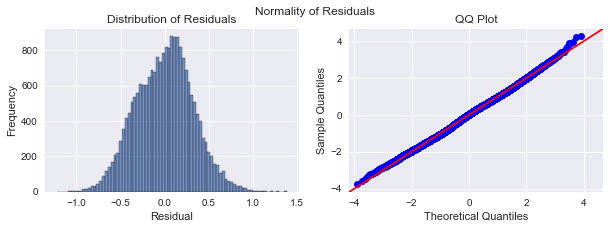

r_sq: 0.5815932946788203. r_sq_adjusted: 0.581319724070073. k_fold_r: 0.5810334217261293


,coef,std err,t,P>|t|,[0.025,0.975]
const,10.7599,0.026,414.760,0.000,10.709,10.811
bedrooms,-0.0184,0.003,-5.697,0.000,-0.025,-0.012
bathrooms,-0.0237,0.005,-4.720,0.000,-0.034,-0.014
sqft_living,0.0002,5.72e-06,26.789,0.000,0.000,0.000
sqft_lot,3.425e-07,7.75e-08,4.422,0.000,1.91e-07,4.94e-07
floors,0.0883,0.005,16.098,0.000,0.078,0.099
grade,0.1671,0.003,49.185,0.000,0.160,0.174
sqft_living15,9.629e-05,5.49e-06,17.533,0.000,8.55e-05,0.000
sqft_lot15,-5.896e-07,1.2e-07,-4.926,0.000,-8.24e-07,-3.55e-07
condition,0.0958,0.004,26.662,0.000,0.089,0.103


In [94]:
model_it_small(Left, target)

### NOTES:
Eveything looks great. I have not other features to add to the model. At this point I will move forward with assumption checks. 

# Assumption Checks:

## Independence Assumption

In [95]:
collinearity(Left)

,cc
pairs,
"(sqft_living15, sqft_living)",0.755058
"(grade, sqft_living)",0.751284


In [96]:
get_VIFs_above5(Left, target)

,0
const,136.070689
sqft_living,5.009482


## Linearity Assumption

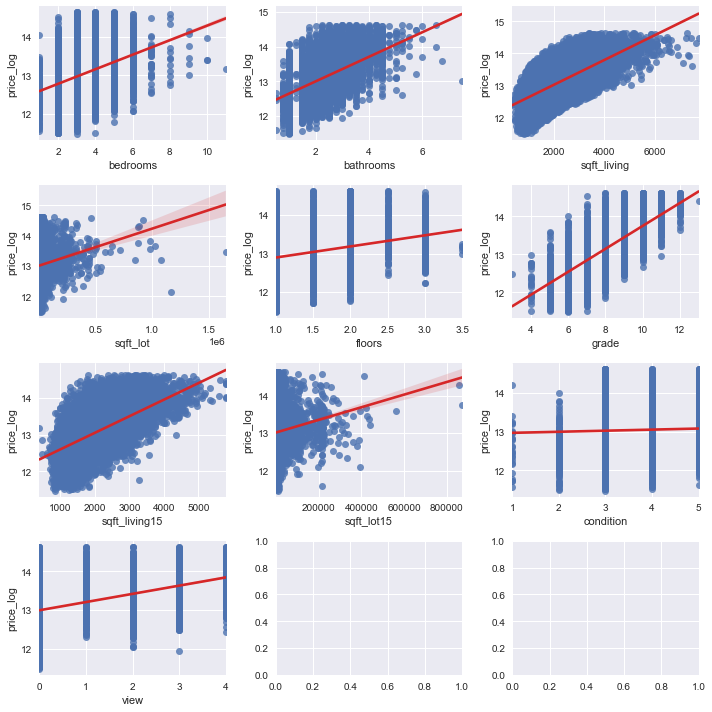

In [98]:
x = Left.drop(['population_type_URBAN', 'season_sold_spring', 'waterfront_YES', 'has_basement_YES'], axis=1)
plots = x.drop(target, axis=1)

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(10, 10))
fig.set_tight_layout(True)

for index, col in enumerate(plots.columns):
    ax = axes[index//3][index%3]
    sns.regplot(x = col, y = target, data = x, ax=ax, line_kws={"color": "tab:red"})
    ax.set_xlabel(col)
    ax.set_ylabel("price_log")

## Homoscedasticity Assumption

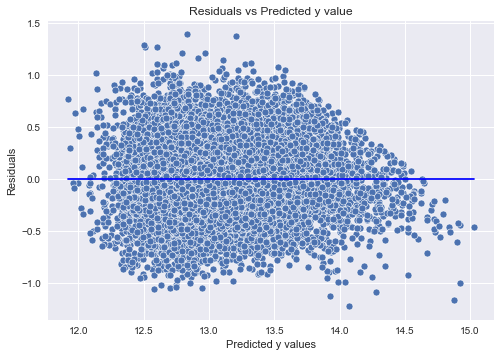

In [99]:
final_model = model(Left, target)

# plot the residuals against predicted values
y_pred = final_model.fittedvalues

# check for homoscedasticity
p = sns.scatterplot(x=y_pred,y=final_model.resid)
plt.xlabel('Predicted y values')
plt.ylabel('Residuals')
#plt.xlim(70,100)
p = sns.lineplot(x=[y_pred.min(),y_pred.max()],y=[0,0],color='blue')
p = plt.title('Residuals vs Predicted y value')

## Normality Assumption

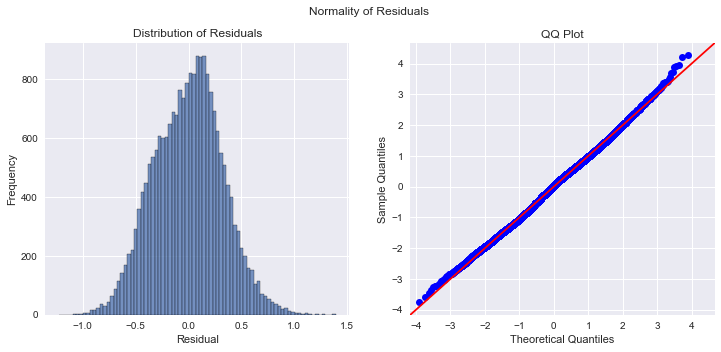

In [100]:
normality_check(Left, target)

### NOTES:
This model passes all the linear regression assumption. I will move one to running full .summary() report and then give recommendations based on this models coefficents. 

# FINAL MODEL

In [101]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     2126.
Date:                Tue, 05 Jul 2022   Prob (F-statistic):               0.00
Time:                        13:16:05   Log-Likelihood:                -6349.4
No. Observations:               21427   AIC:                         1.273e+04
Df Residuals:                   21412   BIC:                         1.285e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.7599      0.026    414.760      0.000      10.709      10.811
bedrooms                 -0.0184      0.003     -5.697      0.000      -0.025      -0.012
bathrooms                -0.0237      0.005     -4.720      0.000      -0.034      -0.014
sqft_living               0.0002   5.72e-06     26.789      0.000       0.000       0.000
sqft_lot               3.425e-07   7.75e-08      4.422      0.000    1.91e-07    4.94e-07
floors                    0.0883      0.005     16.098      0.000       0.078       0.099
grade                     0.1671      0.003     49.185      0.000       0.160       0.174
sqft_living15          9.629e-05   5.49e-06     17.533      0.000    8.55e-05       0.000
sqft_lot15            -5.896e-07    1.2e-07     -4.926      0.000   -8.24e-07   -3.55e-07
condition                 0.0958      0.004     26.662      0.000       0.089       0.103
view                      0.0646      0.003     19.083      0.000       0.058       0.071
has_basement_YES          0.1324      0.005     25.214      0.000       0.122       0.143
waterfront_YES            0.3284      0.033      9.843      0.000       0.263       0.394
season_sold_spring        0.0485      0.005     10.006      0.000       0.039       0.058
population_type_URBAN     0.0761      0.009      8.885      0.000       0.059       0.093
==============================================================================
Omnibus:                        6.020   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                5.825
Skew:                           0.022   Prob(JB):                       0.0544
Kurtosis:                       2.932   Cond. No.                     7.60e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Final Recommendations:

In [102]:
# predictor coeffiecients as percent change, and converted to a pandas df
coeffs_as_percent_df(Left, target)

,coeff,change_in_target
0,bedrooms,-1.84%
1,bathrooms,-2.37%
2,sqft_living,0.02%
3,sqft_lot,0.0%
4,floors,8.83%
5,grade,16.71%
6,sqft_living15,0.01%
7,sqft_lot15,-0.0%
8,condition,9.58%
9,view,6.46%


<a id='final_recos'></a>

### Renovations should be focused on upgrading Condition and Grade of the home. Additionally, adding a basement will increase value. 

The top ways renovations can increase home value: 
-	For every 1 unit increase in **_grade_** classification, the home value will increase by **16.71%**
-	For every 1 unit increase in **_condition_** classification, the home will increase value by **9.58%**
- Having a **_basement_** will increase the value of the home by **13.24%**
 

Below I have placed reminders of the description of _GRADE_ and _CONDITION_ from [table](#table) at top of this notebook. As well as additional information from the King County [Residential Glossary of Terms](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#top), and the [values](#values) from the data.


__GRADE__: _Overall grade of the house. Related to the construction and design of the house. Classification by construction quality which refers to the types of materials used and the quality of workmanship. Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value. (See Glossary in Area Report for Residential Building Grades in use by the King County Department of Assessments.)_  

Classifications:
- 3 – Poor
- 4 – Low
- 5 – Fair
- 6 – Low Average
- 7 – Average
- 8 – Good 
- 9 - Better         
- 10 - Very Good    
- 11 - Excellent     
- 12 - Luxury          
- 13 - Mansion        

__CONDITION__: _How good the overall condition of the house is. Related to maintenance of house._ 

Classifications:
- Average     
- Good         
- Very Good     
- Fair           
- Poor            



# Conclusions on Final Model
Based on the values below, I am confident in the above recommendations.

### P values

Up until this point P-values have been the primary focus. Rightfully so, as the measurement of how likely a coefficient is measured through our model by chance, they are undoubtably important. However, they are not the only value to focus on.

### R squared 

R-squared is the measurement of how much of the independent variable is explained by changes in our dependent variables. In our case, the *r squared* value of 0.582 tells us this final linear regression model is able to explain 58.2% of the variability observed in Sale Price. Because *r squared* will always increase as features are added, in this case 14 as shown in *Df Model*, we should also look to the *adjusted r squared* to get a better understanding of how the model is performing.

### Adjusted R squared

*Adjusted r squared* takes into account the number of features in the model by penalizing the R-squared formula based on the number of variables. If the two were significantly different it could be that some variables are not contributing to your model’s R-squared properly. In this case, the *adjusted r squared* is essentially the same as the *r squared*, just 0.1% diffence, so we can be confident in the 58% reliability, as stated above, of this model. 

### F statistic and Prob(f-statistic)

The f statistic is also important. More easily understood is the prob(f-statistic), it uses the F statistic to tell the accuracy of the null hypothesis, or whether it is accurate that the variables’ effect is 0. In our case, it is telling us 0.00% chance of this. 

# Next Steps

- I'd like to boost r-squared a bit higher. Finding a way to use `'yr_built'` could help. 



## Thank you!
__Email:__ cassigroesbeck@emailplace.com

__GitHub:__ @AgathaZareth

__LinkedIn:__ linkedin.com/in/cassarra-groesbeck-a64b75229